In [38]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.singleheadattention import SingleHeadAttention

In [2]:
# Use GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
        device = torch.device("cpu")
print("Using device:", device)

Using device: mps


# Data generation


In [116]:
import importlib
import utils.generate_data
importlib.reload(utils.generate_data)
from utils.generate_data import generate_data

In [5]:
# Parameters
batch_size = 50
n_train    = 100
n_test     = 100
d          = 11000
rho        = 5.0
eta        = 0.1
beta       = 0.025  

In [6]:
X_train_np, y_train_np, clean_indices_train, noisy_indices_train = generate_data(n_train, d, rho, eta= 0.1, seed=1)
X_test_np,  y_test_np, clean_indices_test, noisy_indices_test = generate_data(n_test, d, rho, eta= 0.1, seed=2)


X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_np, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test_np, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test_np, dtype=torch.float32, device=device)


X_train[clean_indices_train].shape

torch.Size([89, 2, 11000])

# Gradient Descent

In [117]:
import importlib
import utils.train_model
importlib.reload(utils.train_model)
from utils.train_model import train_with_max_margin, train_with_gradient_descent, train_plot, plot_metrics

### Training with Gradient Descent

Epoch 1
Epoch 50
Epoch 100
Epoch 150


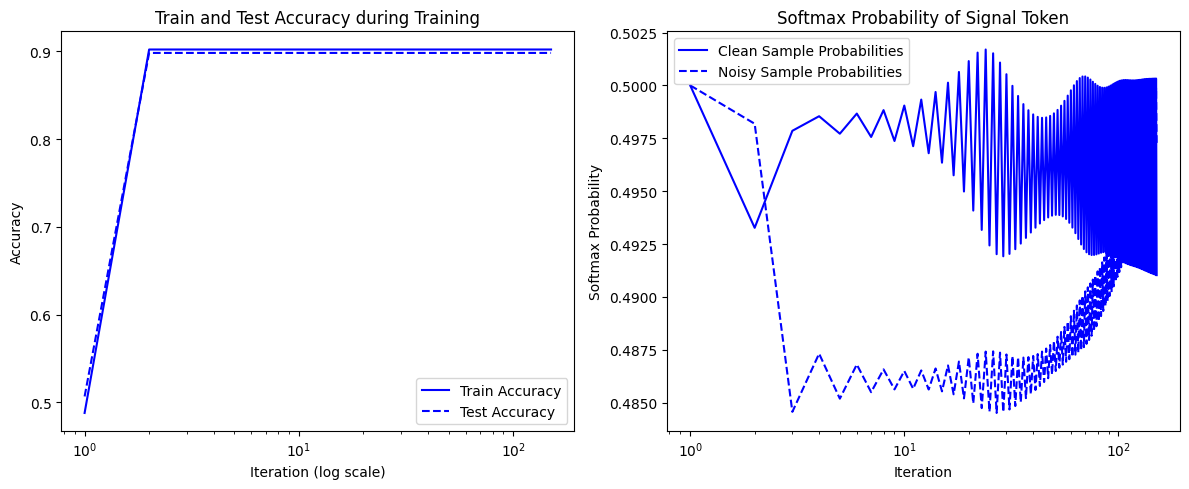

In [118]:
# Model and Optimizer
model_gradient_descent = SingleHeadAttention(d).to(device)
optimizer_gradient_descent = torch.optim.SGD(model_gradient_descent.parameters(), lr=beta)

model_with_gradient_descent = train_with_gradient_descent(model_gradient_descent, 
                                                          optimizer_gradient_descent, 
                                                          X_train, 
                                                          y_train, 
                                                          X_test, 
                                                          y_test, 
                                                          clean_indices_train, 
                                                          noisy_indices_train,
                                                          beta=beta)

### Max-Margin Solution

In [10]:
# Parameters
r = np.sqrt(d)
R = np.sqrt(d)
margin_lambda = 1.0

Epoch 1
Epoch 50
Epoch 100
Epoch 150


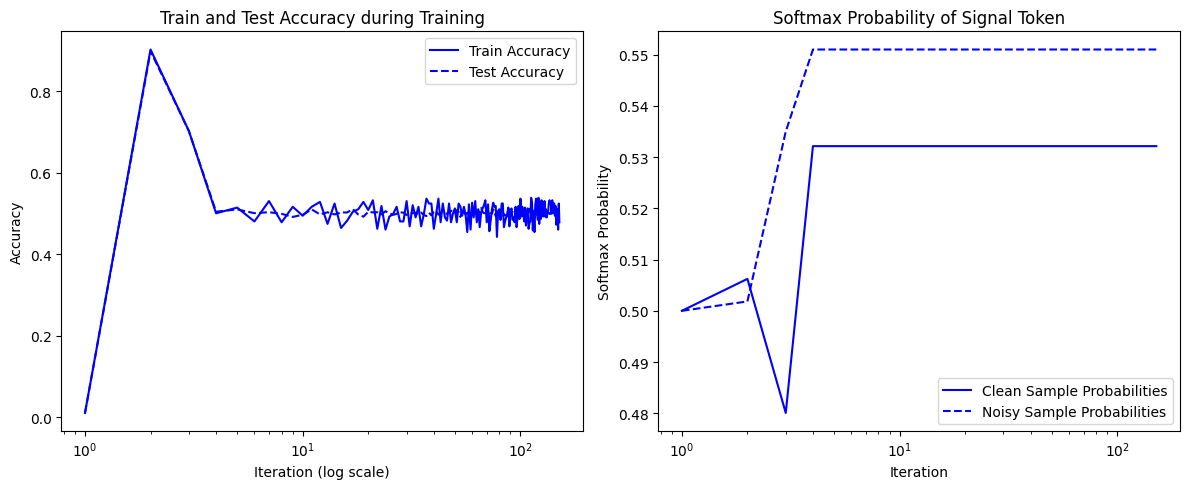

In [119]:
model_max_margin = SingleHeadAttention(d).to(device)
optimizer_max_margin = torch.optim.SGD(model_max_margin.parameters(), lr=beta)

train_accs, test_accs, clean_proba, noisy_proba = train_with_max_margin(model_gradient_descent, 
                                                                        optimizer_gradient_descent, 
                                                                        X_train, 
                                                                        y_train, 
                                                                        X_test, 
                                                                        y_test, 
                                                                        clean_indices_train, 
                                                                        noisy_indices_train, (r,R))

plot_metrics([train_accs], [test_accs], [clean_proba], [noisy_proba])